In [71]:
#import required libraries
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from datetime import datetime
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
pyplot.style.use('fivethirtyeight')

In [72]:
df = pd.read_csv('DAT_MT_EURUSD_M1_2016.csv', sep=',', 
                 parse_dates={'DT' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='DT')


In [73]:
df.head(5)

,OPEN,HIGH,LOW,CLOSE,Volume
DT,,,,,
2016-01-03 17:00:00,1.08701,1.08713,1.08701,1.08713,0
2016-01-03 17:01:00,1.08712,1.08712,1.08712,1.08712,0
2016-01-03 17:02:00,1.08708,1.08722,1.08708,1.08722,0
2016-01-03 17:03:00,1.08717,1.08723,1.08717,1.08723,0
2016-01-03 17:04:00,1.08718,1.08718,1.08711,1.08711,0


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 372679 entries, 2016-01-03 17:00:00 to 2016-12-30 16:58:00
Data columns (total 5 columns):
OPEN      372679 non-null float64
HIGH      372679 non-null float64
LOW       372679 non-null float64
CLOSE     372679 non-null float64
Volume    372679 non-null int64
dtypes: float64(4), int64(1)
memory usage: 17.1 MB


In [75]:
df.dtypes

OPEN      float64
HIGH      float64
LOW       float64
CLOSE     float64
Volume      int64
dtype: object

In [76]:
len(df)

372679

In [77]:
df.shape

(372679, 5)

In [78]:
df.describe

<bound method NDFrame.describe of                         OPEN     HIGH      LOW    CLOSE  Volume
DT                                                             
2016-01-03 17:00:00  1.08701  1.08713  1.08701  1.08713       0
2016-01-03 17:01:00  1.08712  1.08712  1.08712  1.08712       0
2016-01-03 17:02:00  1.08708  1.08722  1.08708  1.08722       0
2016-01-03 17:03:00  1.08717  1.08723  1.08717  1.08723       0
2016-01-03 17:04:00  1.08718  1.08718  1.08711  1.08711       0
2016-01-03 17:05:00  1.08703  1.08716  1.08701  1.08712       0
2016-01-03 17:06:00  1.08721  1.08721  1.08710  1.08710       0
2016-01-03 17:07:00  1.08712  1.08715  1.08712  1.08712       0
2016-01-03 17:08:00  1.08711  1.08720  1.08711  1.08713       0
2016-01-03 17:09:00  1.08716  1.08723  1.08708  1.08708       0
2016-01-03 17:10:00  1.08707  1.08707  1.08700  1.08700       0
2016-01-03 17:11:00  1.08700  1.08700  1.08663  1.08663       0
2016-01-03 17:12:00  1.08663  1.08663  1.08663  1.08663       0
2016-0

In [79]:
df.columns

Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'Volume'], dtype='object')

In [80]:
## finding all columns that have nan:

droping_list_all=[]
for j in range(0,5):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
        #print(df.iloc[:,j].unique())
droping_list_all

[]

In [81]:
# filling nan with mean in any columns

for j in range(0,5):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [82]:
# another sanity check to make sure that there are not more any nan
df.isnull().sum()

OPEN      0
HIGH      0
LOW       0
CLOSE     0
Volume    0
dtype: int64

In [83]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 


In [84]:
## resampling of data over hour
df_resample = df.resample('h').mean() 
df_resample.shape

(8688, 5)

In [85]:
df_resample.head(5)

,OPEN,HIGH,LOW,CLOSE,Volume
DT,,,,,
2016-01-03 17:00:00,1.086829,1.086863,1.086780,1.086817,0.0
2016-01-03 18:00:00,1.085373,1.085438,1.085290,1.085345,0.0
2016-01-03 19:00:00,1.084998,1.085068,1.084926,1.084987,0.0
2016-01-03 20:00:00,1.084145,1.084272,1.084054,1.084167,0.0
2016-01-03 21:00:00,1.086463,1.086611,1.086362,1.086483,0.0


In [86]:
## * Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
values = df_resample.values 


## full data without resampling
values = df.values

# integer encode direction
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,7,8,9]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)
1   0.410176   0.409576   0.412505   0.411233        0.0  0.411048
2   0.411048   0.409498   0.413382   0.411154        0.0  0.410730
3   0.410730   0.410291   0.413062   0.411945        0.0  0.411444
4   0.411444   0.410370   0.413779   0.412024        0.0  0.411523
5   0.411523   0.409974   0.413301   0.411075        0.0  0.410335


In [87]:
# split into train and test sets
values = reframed.values

#8688 * 0.7 =6081

n_train_time = 8688
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(8688, 1, 5) (8688,) (363990, 1, 5) (363990,)


In [88]:
## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [89]:
# model = Sequential()
# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), activation='tanh', return_sequences = True))
# model.add(LSTM(25, activation = 'tanh'))
# #model.add(LSTM(6))
# model.add(Dense(1, activation = 'sigmoid'))
# model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics = ['accuracy'])

Train on 8688 samples, validate on 363990 samples
Epoch 1/20
 - 5s - loss: 0.0175 - val_loss: 0.0068
Epoch 2/20
 - 5s - loss: 6.9361e-04 - val_loss: 0.0066
Epoch 3/20
 - 5s - loss: 6.5967e-04 - val_loss: 0.0071
Epoch 4/20
 - 5s - loss: 6.1696e-04 - val_loss: 0.0074
Epoch 5/20
 - 5s - loss: 5.8816e-04 - val_loss: 0.0077
Epoch 6/20
 - 5s - loss: 5.6816e-04 - val_loss: 0.0085
Epoch 7/20
 - 5s - loss: 5.4417e-04 - val_loss: 0.0093
Epoch 8/20
 - 5s - loss: 5.2148e-04 - val_loss: 0.0102
Epoch 9/20
 - 5s - loss: 5.1169e-04 - val_loss: 0.0101
Epoch 10/20
 - 5s - loss: 4.8714e-04 - val_loss: 0.0109
Epoch 11/20
 - 5s - loss: 4.7431e-04 - val_loss: 0.0104
Epoch 12/20
 - 5s - loss: 4.2685e-04 - val_loss: 0.0107
Epoch 13/20
 - 5s - loss: 4.5228e-04 - val_loss: 0.0115
Epoch 14/20
 - 5s - loss: 4.3016e-04 - val_loss: 0.0108
Epoch 15/20
 - 5s - loss: 4.2553e-04 - val_loss: 0.0110
Epoch 16/20
 - 5s - loss: 4.0189e-04 - val_loss: 0.0104
Epoch 17/20
 - 5s - loss: 3.8826e-04 - val_loss: 0.0108
Epoch 18/20

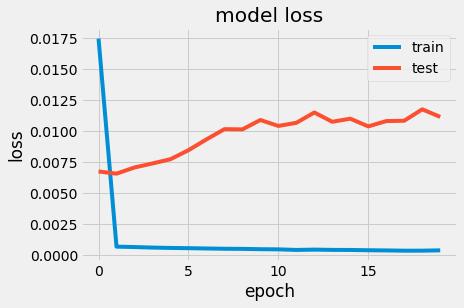

Test RMSE: 0.013


In [90]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))

#model.add(LSTM(25, activation = 'tanh'))
# model.add(LSTM(70,activation = 'tanh'))
# model.add(Dropout(0.3))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper right')
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 5))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

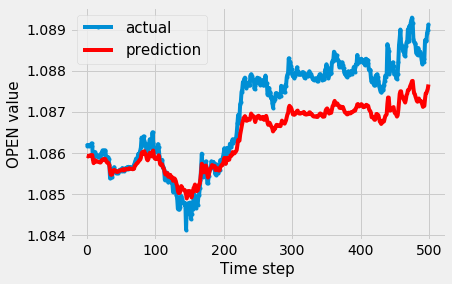

In [91]:
## time steps, every step is one hour (you can easily convert the time step to the actual time index)
## for a demonstration purpose, I only compare the predictions in 200 hours. 

aa=[x for x in range(500)]
pyplot.plot(aa, inv_y[:500], marker='.', label="actual")
pyplot.plot(aa, inv_yhat[:500], 'r', label="prediction")
pyplot.ylabel('OPEN value', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)
pyplot.show()

In [23]:
# define one new instance
# Xnew = (2017-1-3 10:0:0)